In [83]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -p numpy,sklearn,pandas
%watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
%watermark -p torch,torchvision,torchaudio
# %watermark -p tensorflow,tensorboard,tflite
# %watermark -p onnx,tf2onnx,onnxruntime,tensorrt,tvm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
# %config IPCompleter.use_jedi = False

# %matplotlib widget
# from IPython.display import display, Markdown, HTML, IFrame, Image, Javascript
# from IPython.core.magic import register_line_cell_magic, register_line_magic, register_cell_magic
# display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil
import argparse, shlex, signal
import numpy as np
import scipy.io as sio
import torch

np.set_printoptions(
    edgeitems=3, infstr='inf',
    linewidth=75, nanstr='nan', precision=6,
    suppress=True, threshold=100, formatter=None)

argparse.ArgumentParser.exit = lambda *arg, **kwargs: _IGNORE_

def _IMPORT(x, tag='main', debug=False):
    def __request_text(url):
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        else:
            raise RuntimeError(url)
    try:
        x = x.strip()
        if x[0] == '/' or x[1] == '/':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                x = 'https://' + x
                x = __request_text(x)
            elif x.startswith('github.com'):
                x = x.replace('github.com', 'raw.githubusercontent.com')
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/{tag}/' + '/'.join(mod[-3:])
                x = __request_text(x)
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/raw/{tag}/' + '/'.join(mod[3:])
                x = __request_text(x)
        if debug:
            return x
        else:
            exec(x, globals())
    except Exception as err:
        # sys.stderr.write(f'request {x} : {err}')
       pass

def _DIR(x, dumps=True, ret=True):
    attrs = sorted([y for y in dir(x) if not y.startswith('_')])
    result = '%s: %s' % (str(type(x))[8:-2], json.dumps(attrs) if dumps else attrs)
    if ret:
        return result
    print(result)

_IMPORT('./easy_widget.py')

numpy  : 1.22.3
sklearn: 1.0.2
pandas : 1.4.1

ipywidgets: 7.7.1
cv2       : 4.8.1
PIL       : 9.0.1
matplotlib: 3.5.1
plotly    : 5.18.0
netron    : not installed

torch      : 1.12.0.dev20220327+cpu
torchvision: 0.13.0.dev20220327+cpu
torchaudio : 0.12.0.dev20220327+cpu



In [71]:

###
### Display ###
###

_IMPORT('import pandas as pd')
_IMPORT('import cv2')
_IMPORT('from PIL import Image')
_IMPORT('import matplotlib.pyplot as plt')
_IMPORT('import plotly')
_IMPORT('import plotly.graph_objects as go')
_IMPORT('import ipywidgets as widgets')
_IMPORT('from ipywidgets import interact, interactive, fixed, interact_manual')

# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)
# from matplotlib.font_manager import FontProperties
# simsun = FontProperties(fname='/sysfonts/simsun.ttc', size=12)


def _imread(imgin):
    is_bytes = isinstance(imgin, bytes)
    if is_bytes or imgin.startswith('http'):
        if not is_bytes:
            response = requests.get(imgin)
            if response:
                imgin = response.content
            else:
                raise
        img = cv2.imdecode(np.frombuffer(imgin, dtype=np.uint8), cv2.IMREAD_COLOR)
    else:
        img = cv2.imread(imgin)
    return img

def _imshow(image, title=None, color='bgr', figsize=(6, 3), canvas=False):
    import IPython
    plt.close('all')
    if figsize == 'auto':
        ih, iw = image.shape[:2]
        fw, fh = int(1.5 * iw / 80) + 1, int(1.5 * ih / 80) + 1
        if fw > 32:
            fh = int(32 * (fh / fw))
            fw = 32
        figsize = (fw, fh)
    if canvas:
        IPython.get_ipython().enable_matplotlib(gui='widget');
        fig = plt.figure(figsize=figsize)
        fig.canvas.toolbar_position = 'left'
        fig.canvas.toolbar_visible = True
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = True
    else:
        IPython.get_ipython().enable_matplotlib(gui='inline')
        fig = plt.figure(figsize=figsize)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    if color == 'gray' or len(image.shape) == 2:
        plt.imshow(image, cmap='gray');
    else:
        if color == 'bgr':
           image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image);

## Global Variables and Functions

In [85]:
TOP_DIR='/jupyter/hzcsbet/gamebet'
CKPTS_DIR = f'{TOP_DIR}/checkpoints'
HEIGHT, WIDTH = 720, 1280
yard2meter = 0.9144
template_h, template_w = int(74 * yard2meter) + 2, int(115 * yard2meter) + 2
interpolation = cv2.INTER_AREA

sys.path.append(TOP_DIR)
    
if not os.path.isdir(CKPTS_DIR):
    raise '!!! network weights !!!'
    
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:{}'.format(args.cuda_id))
    cudnn.benchmark = True

seg_G_weights_path = f'{CKPTS_DIR}/seg_G.pth'
det_G_weights_path = f'{CKPTS_DIR}/det_G.pth'
siamese_weights_path = f'{CKPTS_DIR}/siamese.pth'

    
video_url_prefix = 'https://gamebet-1301930378.cos.ap-beijing.myqcloud.com/dfl-bundesliga-data-shootout/test'
video_mp4_files = [
    '019d5b34_1.mp4',
    '947e05ca_1.mp4',
    '9d3c239b_1.mp4',
    'e9d974aa_0.mp4',
    'ef4c2eb9_1.mp4',
]

## Load Network

In [92]:
from models.networks import define_G
from models.siamese import SiameseNetwork

###  Seg Generate Net

In [91]:
seg_G_net = define_G(input_nc=3, output_nc=1, ngf=64, netG='unet_256')
state_dict = torch.load(seg_G_weights_path, map_location=device)
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
seg_G_net.load_state_dict(state_dict)
seg_G_net.to(device);

initialize network with normal


### Det Generate Net

In [90]:
det_G_net = define_G(input_nc=3, output_nc=1, ngf=64, netG='unet_256')
state_dict = torch.load(det_G_weights_path, map_location=device)
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
det_G_net.load_state_dict(state_dict)
det_G_net.to(device);

initialize network with normal


### Siamese Net

In [ ]:
SiameseNetwork

In [51]:
w_video, w_image = nbeasy_show_video(f'{video_url_prefix}/{video_mp4_files[2]}')

Box(children=(Box(children=(VBox(children=(HBox(children=(VBox(children=(VideoE(value=b'https://gamebet-130193…

(12, 6)


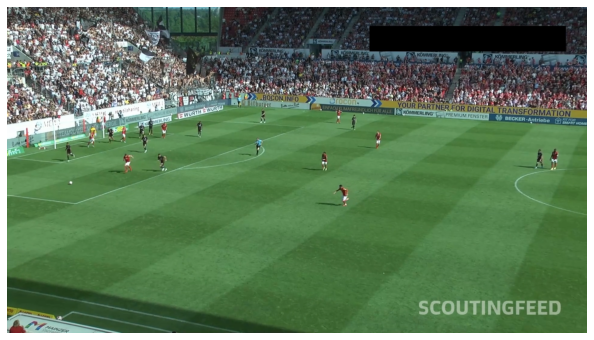

In [73]:
_imshow(_imread(w_image.value), figsize=(12, 6))